### Comparing a pair of ACS Census Variables

In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import cenpy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

scaler = StandardScaler()
%matplotlib inline


data = pd.read_csv('./data/data.csv')

In [2]:
data.head()

,Label,200k or more,"100k to $149,999","75k to $99,999",Age 18-24 Bachelor's degree or higher
0,Alabama Nonfamily households Estimate,0.012,0.051,0.066,0.091
1,Alaska Nonfamily households Estimate,0.027,0.129,0.107,0.035
2,Arizona Nonfamily households Estimate,0.033,0.096,0.100,0.105
3,Arkansas Nonfamily households Estimate,0.012,0.049,0.069,0.097
4,California Nonfamily households Estimate,0.076,0.130,0.110,0.122


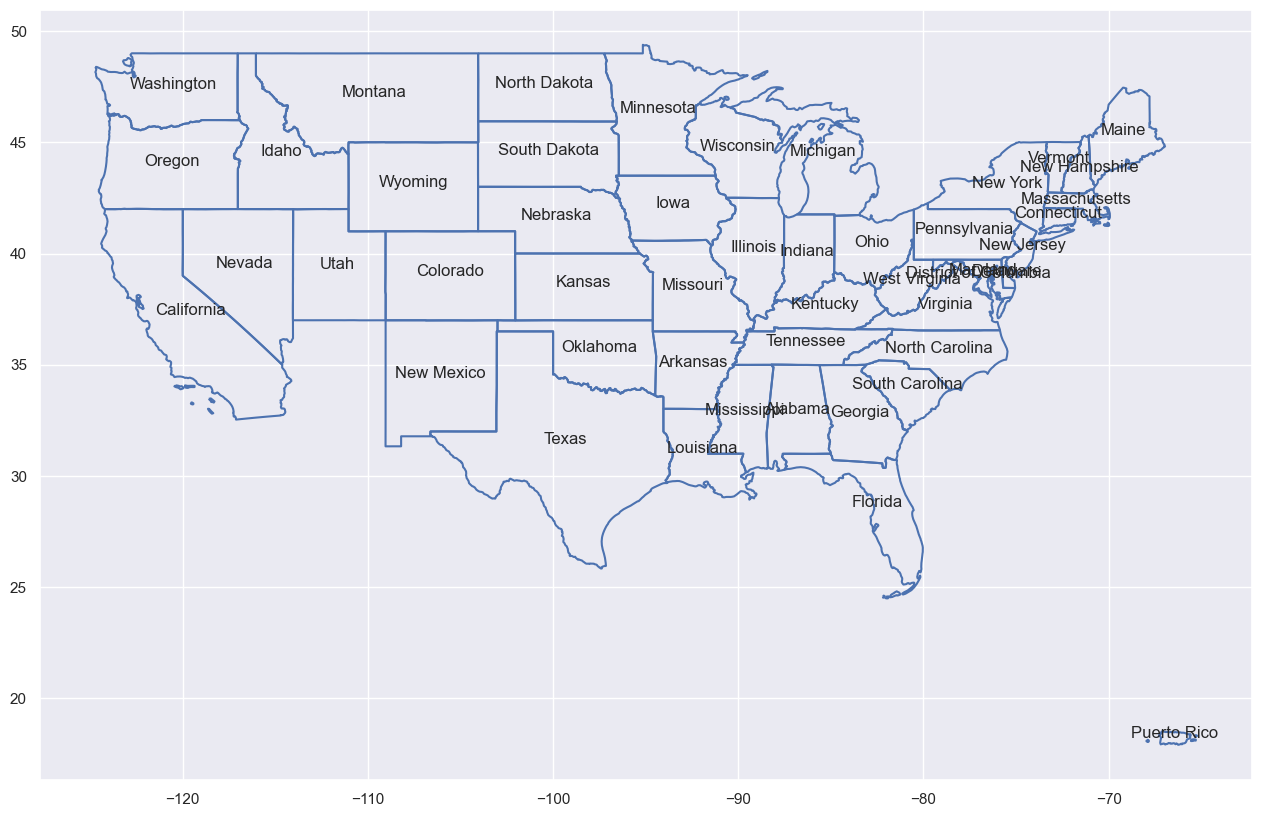

In [3]:
data = data.drop("Label", axis=1)

data = data.apply(lambda x: x * 100) 

gdf = gpd.read_file("./data/us-shapefile-states-data/COVID-19_global_time_series_panel_data-master/data/cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
gdf = gdf.to_crs("EPSG:4326")


gdf = gdf[gdf.NAME!="Hawaii"]
gdf = gdf[gdf.NAME!="Alaska"]
gdf = gdf[['NAME', 'geometry']]
# gdf.head()

newdf = pd.concat([gdf, data], axis=1)
# newdf = newdf.drop('id', axis=1)

newdf['lon'] = newdf['geometry'].centroid.x
newdf['lat'] = newdf['geometry'].centroid.y

# newdf.head()
# newdf.dtypes

newdf = newdf.dropna()

newgdf = GeoDataFrame(newdf, crs="EPSG:4326")  # change the EPSG, see whether the result changes
ax = newgdf.boundary.plot()    
newgdf.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [4]:
newgdf.head()

,NAME,geometry,200k or more,"100k to $149,999","75k to $99,999",Age 18-24 Bachelor's degree or higher,lon,lat
0,Maryland,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",1.2,5.1,6.6,9.1,-76.751039,39.028056
1,Iowa,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",2.7,12.9,10.7,3.5,-93.498960,42.074917
2,Delaware,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",3.3,9.6,10.0,10.5,-75.500949,39.000628
3,Ohio,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",1.2,4.9,6.9,9.7,-82.791383,40.295417
4,Pennsylvania,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",7.6,13.0,11.0,12.2,-77.799544,40.874158


In [2]:
# df = pd.read_csv('merged_acs.csv')

In [5]:
# df.head()

In [6]:
# df.drop('geometry', axis=1, inplace=True)

In [7]:
# counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
#                                                                             .sort_values(by='id').reset_index(drop=True)

# empty = counties['geometry'].is_empty
# counties_non_empty = counties[~empty]

# counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
# counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
# counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [6]:
# data = df.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')

In [7]:
# data.drop(['name', 'id'], axis=1, inplace=True)
# data.drop(data[(data.GEOID >= 15000) & (data.GEOID < 16000)].index, inplace=True)
# data.drop(data[(data.GEOID >= 2000) & (data.GEOID < 4000)].index, inplace=True)

In [8]:
# newgdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

In [8]:
# newgdf.boundary.plot()

In [9]:
# newgdf.head()

### Modelling

In [10]:
g_y = newgdf["Age 18-24 Bachelor's degree or higher"].values.reshape((-1,1))
g_X = newgdf[["200k or more"]].values

u = newgdf["lon"]
v = newgdf["lat"]

g_coords = list(zip(u,v))

In [11]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
gwr_results_o.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                  48
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             35.114
Log-likelihood:                                                     -60.607
AIC:                                                                125.214
AICc:                                                               127.759
BIC:                                                               -142.961
R2:                                                                   0.268
Adj. R2:                                                              0.253

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

### GW Correlation Coefficient. Classic 

In [12]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
newgdf['gwr_calc'] = corr_mat
corr_mat.mean()

0.5166378752930401

### Calculate GW CC using the new algorithm 

In [13]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()
gwr_results_n.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                  48
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1155.744
Log-likelihood:                                                    -144.460
AIC:                                                                290.920
AICc:                                                               293.187
BIC:                                                                973.798
R2:                                                                  -1.189
Adj. R2:                                                             -1.189

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [14]:
newgdf['new_algo_params'] = gwr_results_n.params

In [15]:
from utils import compare_surfaces

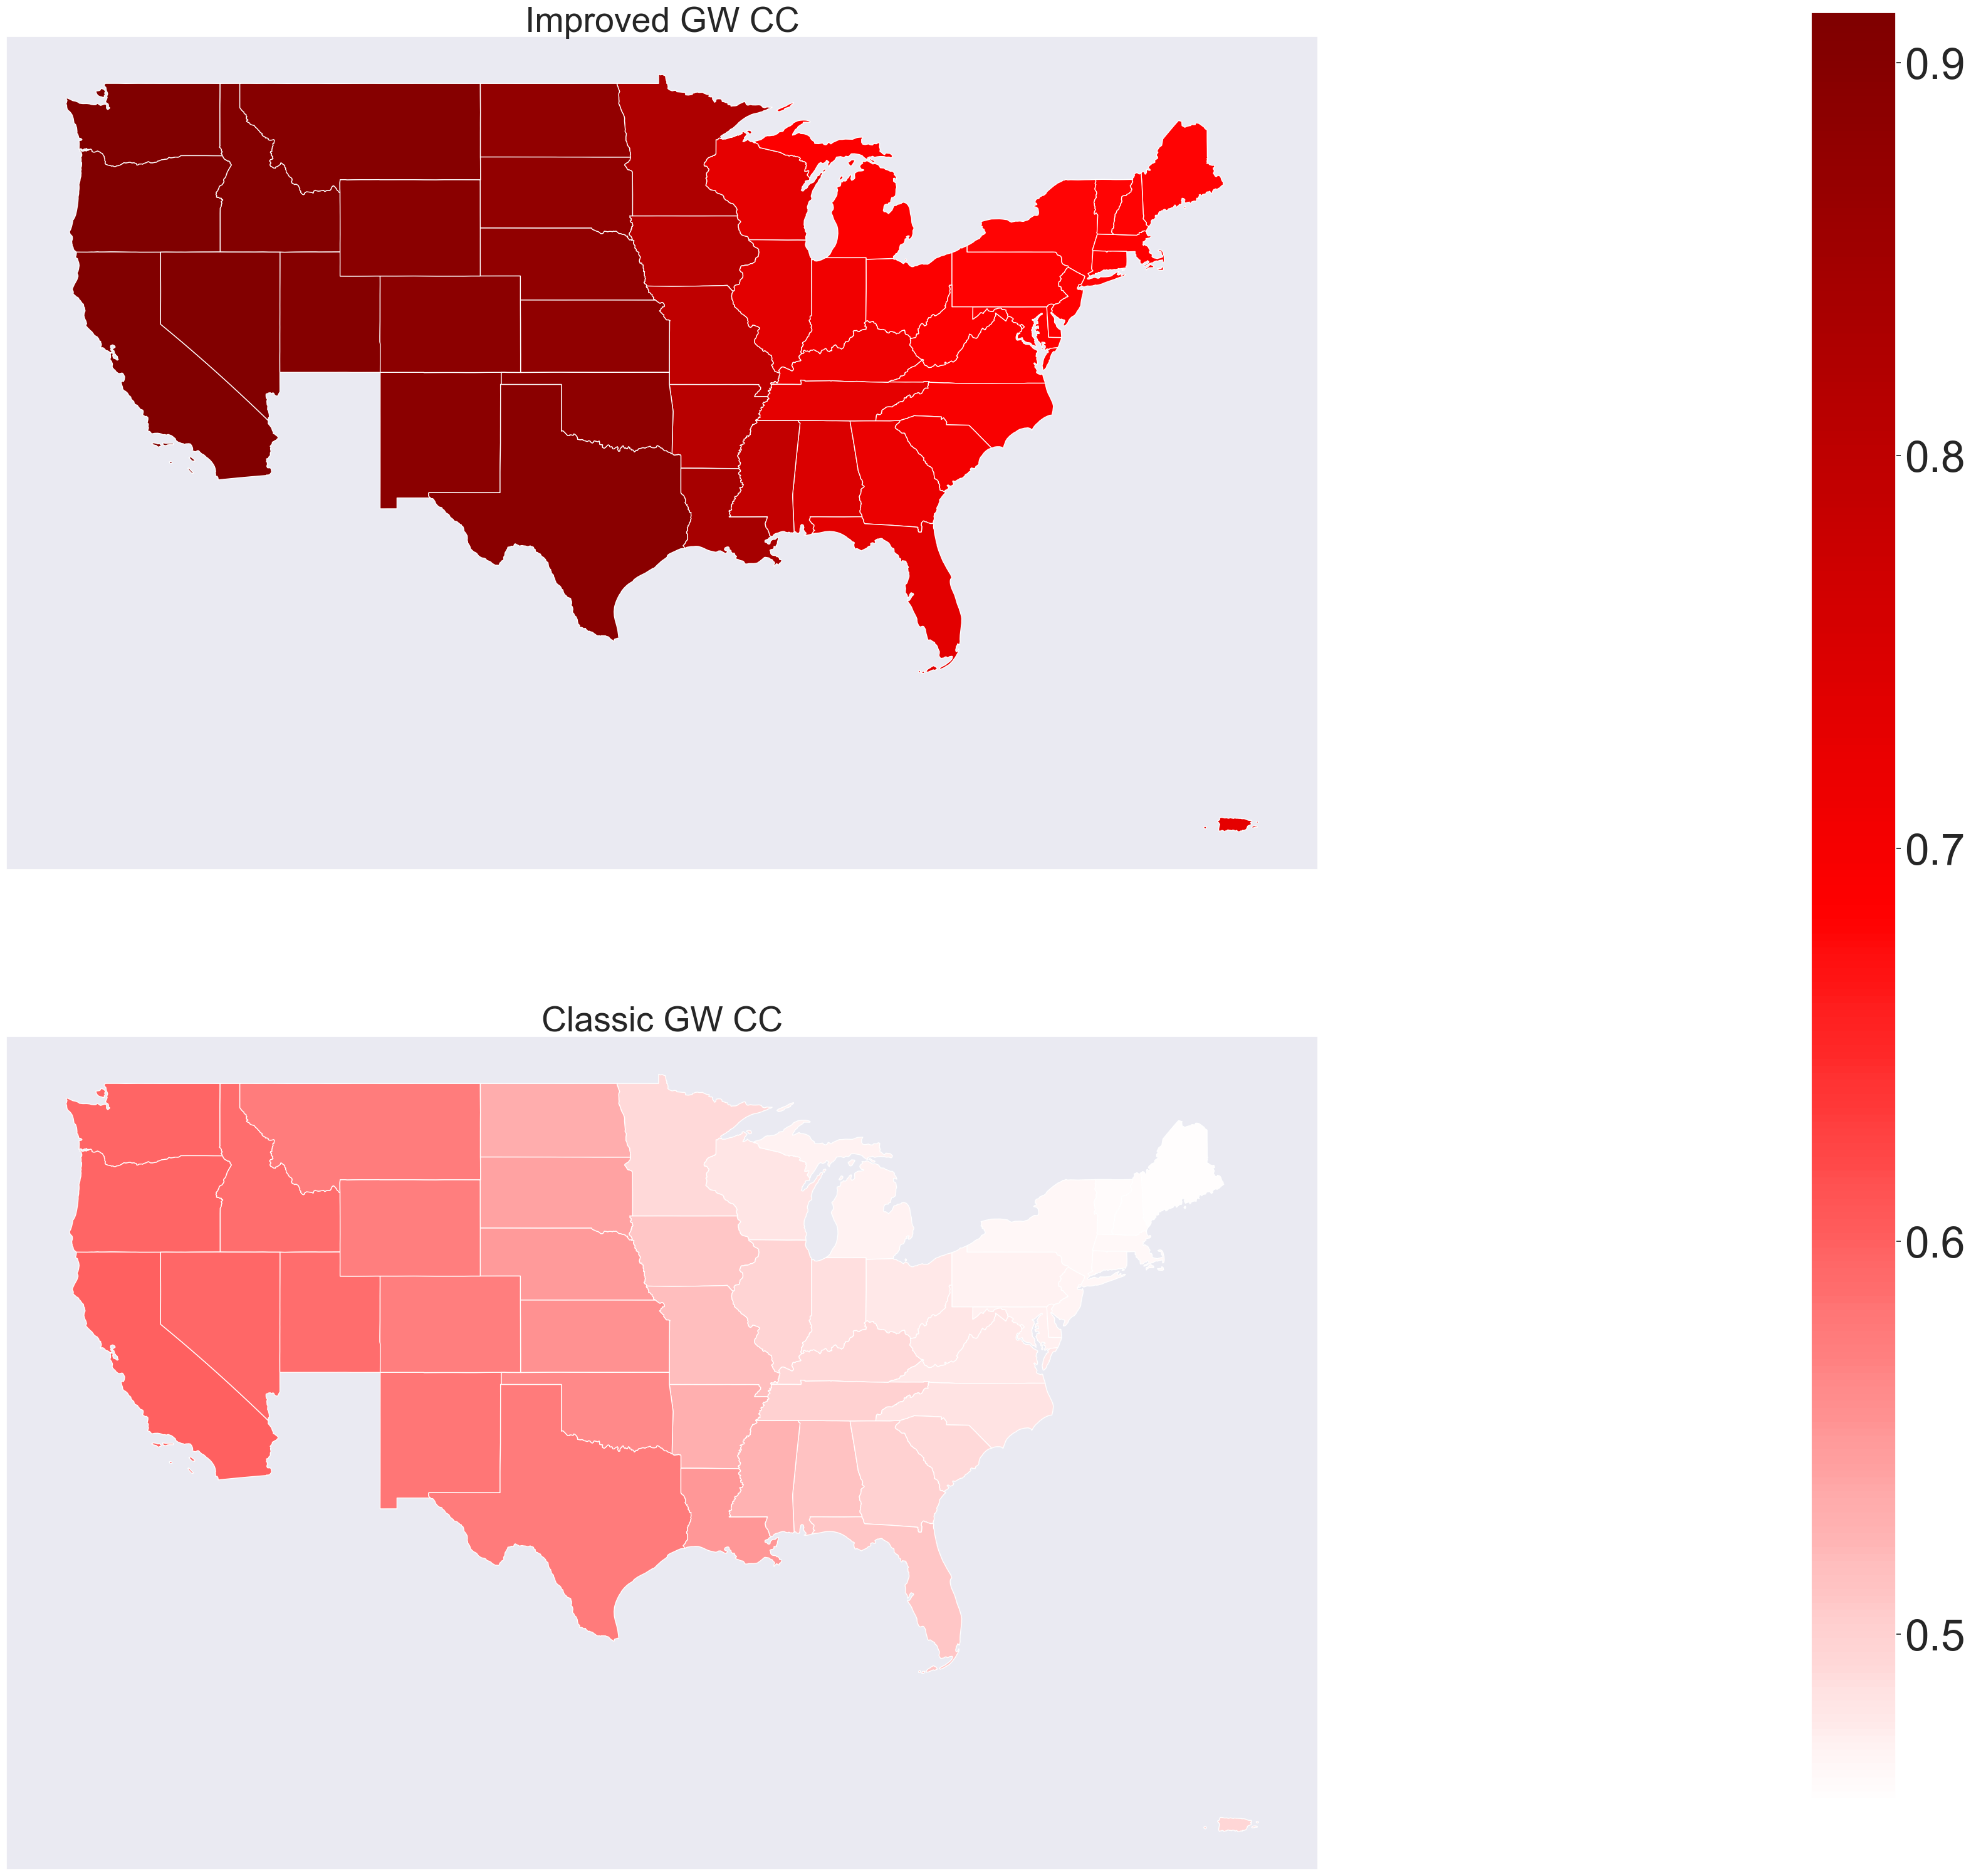

In [16]:
compare_surfaces(newgdf, 'new_algo_params', 'gwr_calc', savefig='./figs/usecase1-states.png')

   ### Locally Weighted Pearson'sR 

In [18]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_n.model._build_wi(i, gwr_bw_n).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

0.9415197213233601